In [1]:
%matplotlib inline

# Model Building Part 2

Code for building the models  
_Author: Jimmy Charité_  
_Email: jimmy.charite@gmail.com_  

Following up with part one, I will try the bag of words approach

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import Image
from IPython.core.display import HTML

In [3]:
retval=os.chdir("..")

In [4]:
clean_data=pd.read_pickle('./clean_data/clean_data.pkl')

In [5]:
clean_data.head()

,helpful,num_sents,num_words,readability,neg_senti,pos_senti,neu_senti,comp_senti,text_lemma,vec0,...,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299
0,0.0,0.693147,3.610918,6.742881,0.079,0.068,0.853,-0.1027,product arrive label peanut actually small siz...,-0.019901,...,-0.178709,0.120293,0.048853,-0.028560,0.024294,-0.051074,-0.082868,-0.058978,0.058156,0.020952
1,0.0,1.386294,3.555348,6.734948,0.000,0.448,0.552,0.9468,great taffy great price wide assortment yummy ...,-0.076091,...,-0.125921,0.026862,-0.011833,-0.023788,0.028657,-0.001059,-0.003236,-0.048324,-0.050874,0.113610
2,0.0,1.609438,4.521789,6.743588,0.029,0.163,0.809,0.8830,get wild hair taffy order pound bag taffy enjo...,-0.048797,...,-0.154745,0.004021,0.004185,0.006071,-0.032341,0.030001,0.004792,-0.122627,-0.015319,0.046176
3,0.0,1.609438,4.143135,6.742527,0.034,0.273,0.693,0.9346,saltwater taffy great flavor soft chewy candy ...,-0.009421,...,-0.185385,0.038134,0.014824,-0.012089,0.007642,-0.013590,0.038388,-0.117533,0.042929,0.137415
4,0.0,1.609438,3.526361,6.737915,0.000,0.480,0.520,0.9487,taffy good soft chewy flavor amazing definitel...,-0.073490,...,-0.155703,0.041312,-0.121036,-0.063175,0.075995,-0.005276,0.051416,-0.136569,0.021066,0.123007


In [6]:
kept_cols=['helpful', 'text_lemma']

## Training and Testing Split

In [7]:
my_rand_state=0
test_size=0.25

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = (clean_data[kept_cols].iloc[:,1]).tolist()
y = (clean_data[kept_cols].iloc[:,0]).tolist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                              random_state=my_rand_state)

## Text

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
#set max_features to minimize training time
#also, I didn't apply LDA-based dimensionality reduction
tfidf=TfidfVectorizer(lowercase=False,max_features=200) 

## Classification Models

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Although tuning is not necessary for Naive Bayes, I pass the default parameters of those models to GridSearchCV anyway so that I can do a direct pair-wise comparison with the other models across the different steps of cross-validation.  

In the interest of time, I didn't use the SVM classifier.

In [14]:
nb_clf=GaussianNB()
priors=[None]

In [15]:
qda_clf=QuadraticDiscriminantAnalysis()
reg_param=[0.0, 0.25, 0.5, 0.75]

In [16]:
log_clf=LogisticRegression(penalty='l2')
C=[0.001 , 0.01, 10, 100,1000]

In [17]:
rf_clf=RandomForestClassifier()
n_estimators=[100,200]
max_features=[.1,.3,.5]

In [18]:
class_weight=['balanced']
class_weight.extend([{1: w} for w in [1, 2, 10]])

## Creating Pipelines

In [19]:
from imblearn import pipeline #needed if mixing imblearn with sklearn classes
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

I plan on using imblearn classes for later iterations so I use it's pipeline in the beginning for convenience

In [20]:
n_jobs=4

In [21]:
n_folds=10
skfold = StratifiedKFold(n_splits=n_folds,random_state=my_rand_state, shuffle=False)

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

In [23]:
class DenseTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

#### Naive Bayes Estimators

In [24]:
nb_clf_b = pipeline.Pipeline(steps=[('tfidf',tfidf),('to_dense', DenseTransformer()),('clf',nb_clf)])
nb_clf_est_b = GridSearchCV(estimator=nb_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(clf__priors=priors))

#### QDA Estimators

In [25]:
qda_clf_b = pipeline.Pipeline(steps=[('tfidf',tfidf),('to_dense', DenseTransformer()),('clf',qda_clf)])
qda_clf_est_b = GridSearchCV(estimator=qda_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(clf__reg_param=reg_param))

#### Logistic Estimators

In [26]:
log_clf_b = pipeline.Pipeline(steps=[('tfidf',tfidf),('clf',log_clf)])
log_clf_est_b = GridSearchCV(estimator=log_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(clf__C=C,
                              clf__class_weight=class_weight))

#### Random Forest Estimators

In [27]:
rf_clf_b = pipeline.Pipeline(steps=[('tfidf',tfidf),('clf',rf_clf)])
rf_clf_est_b = GridSearchCV(estimator=rf_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(clf__n_estimators=n_estimators,
                              clf__max_features=max_features,
                              clf__class_weight=class_weight))

## Fitting Estimators

In [28]:
from sklearn.externals import joblib

Basic Estimators: no bag of words or PCA

In [34]:
nb_clf_est_b.fit(X_train,y_train)
joblib.dump(nb_clf_est_b, './other_output/bow/nb_clf_est_b.pkl')

['./other_output/bow/nb_clf_est_b.pkl']

In [35]:
qda_clf_est_b.fit(X_train,y_train)
joblib.dump(qda_clf_est_b, './other_output/bow/qda_clf_est_b.pkl')

['./other_output/bow/qda_clf_est_b.pkl']

In [36]:
log_clf_est_b.fit(X_train,y_train)
joblib.dump(log_clf_est_b, './other_output/bow/log_clf_est_b.pkl')

['./other_output/bow/log_clf_est_b.pkl']

In [37]:
rf_clf_est_b.fit(X_train,y_train)
joblib.dump(rf_clf_est_b, './other_output/bow/rf_clf_est_b.pkl')

['./other_output/bow/rf_clf_est_b.pkl']

## Testing Estimators

In [29]:
from sklearn.metrics import roc_curve, auc

In [30]:
nb_clf_est_b=joblib.load('./other_output/bow/nb_clf_est_b.pkl')
qda_clf_est_b=joblib.load('./other_output/bow/qda_clf_est_b.pkl')
log_clf_est_b=joblib.load('./other_output/bow/log_clf_est_b.pkl')
rf_clf_est_b=joblib.load('./other_output/bow/rf_clf_est_b.pkl')

In [65]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_b.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_b.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_b.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_b.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

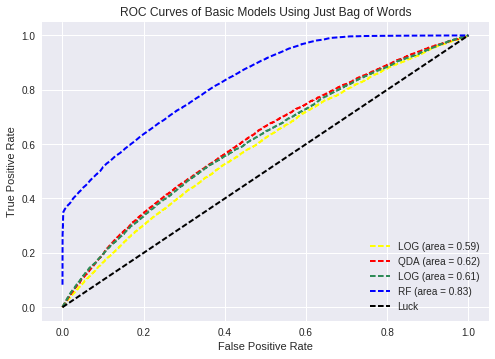

In [66]:
plt.plot(nb_fpr, nb_tpr, color='yellow', linestyle='--',
         label='LOG (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='red', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Basic Models Using Just Bag of Words')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_Basic_BOW.png', bbox_inches='tight')
plt.show()

Closer look at the variability of the best model

In [31]:
from scipy.stats import sem

In [38]:
len(y_test) #the sample is large enough that we can get away with 5% draws

49665

In [56]:
y_test=np.array(y_test)
X_test=np.array(X_test)

In [57]:
#initialize 
n_bootstraps = 2000
rng_seed = 1
sample_percent=0.05
min_index=0
max_index=len(y_test)-1

In [58]:
draw_size=int(len(y_test)*sample_percent)
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)

In [59]:
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on 
    indices = rng.random_integers(min_index, max_index, draw_size)
    
    #calculate ROC from 
    rf_fpr, rf_tpr, _ = roc_curve(y_test[indices], 
                    rf_clf_est_b.predict_proba(X_test[indices])[:,1])
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    
    #save
    bootstrapped_scores.append(rf_roc_auc)

/home/jimmy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 49664 + 1) instead
  app.launch_new_instance()


In [60]:
import pickle

In [61]:
with open('./other_output/bow/rf_bootstrapped_scores.pkl', 'wb') as f:
    pickle.dump(bootstrapped_scores, f)

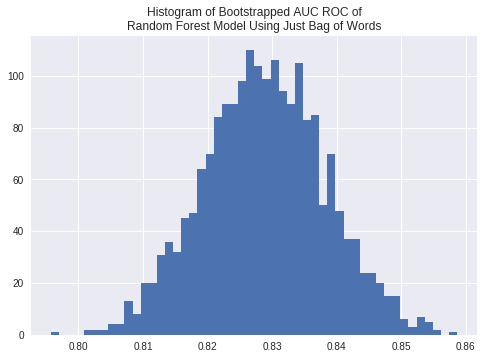

In [63]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of Bootstrapped AUC ROC of\nRandom Forest Model Using Just Bag of Words')
plt.savefig('./plots/ROC_Histogram_Basic_BOW.png', bbox_inches='tight')
plt.show()

In [64]:
pd.DataFrame({'auc':bootstrapped_scores}).auc.describe()

count    2000.000000
mean        0.828858
std         0.009434
min         0.795808
25%         0.822446
50%         0.828828
75%         0.835264
max         0.858646
Name: auc, dtype: float64